In [1]:
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score
)
from sklearn.preprocessing import label_binarize

import os, random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import (
    convnext_tiny, ConvNeXt_Tiny_Weights,
    efficientnet_b0, EfficientNet_B0_Weights
)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Data Augmentation and loading

In [3]:
# Paths
data_dir = r"C:/Users/ZA SEYAM/AgroSpectraNet/data/processed"

# Paths
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")
test_dir  = os.path.join(data_dir, "test")

# Transforms (example, can be tuned)
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_ds = ImageFolder(train_dir, transform=transform_train)
val_ds   = ImageFolder(val_dir, transform=transform_eval)
test_ds  = ImageFolder(test_dir, transform=transform_eval)

# Classes
NUM_CLASSES = len(train_ds.classes)
print("Classes:", NUM_CLASSES, train_ds.classes[:5], "...")  # show sample

# Loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Classes: 30 ['corn_cercospora_leaf_spot', 'corn_common_rust', 'corn_healthy', 'corn_northern_leaf_blight', 'jute_cescospora_leaf_spot'] ...


## Attention fusion + Hybrid model (AgroSpectra)

In [4]:
class AgroSpectraNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ConvNeXt
        self.convnext = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
        self.convnext.classifier = nn.Identity()
        conv_dim = 768  # convnext_tiny last embedding size

        # EfficientNet
        self.effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.effnet.classifier = nn.Identity()
        eff_dim = 1280  # efficientnet_b0 last embedding size

        # Global Avg Pool for both branches
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # Fusion + Classifier
        self.fc = nn.Sequential(
            nn.Linear(conv_dim+eff_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.convnext.features(x)   # [B,768,H,W]
        x1 = self.pool(x1).flatten(1)    # [B,768]

        x2 = self.effnet.features(x)     # [B,1280,H,W]
        x2 = self.pool(x2).flatten(1)    # [B,1280]

        x = torch.cat([x1, x2], dim=1)   # [B,2048]
        return self.fc(x)

# Init model
model = AgroSpectraNet(NUM_CLASSES).to(device)
print(model)

AgroSpectraNet(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((

## Train / Eval loops (AMP + tqdm, GPU-safe)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
scaler = GradScaler()   # ✅ AMP scaler

# --- Training function ---
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        # ✅ autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total

# --- Evaluation function ---
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_29704\1839667932.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # ✅ AMP scaler


## Training Loop

In [5]:
EPOCHS = 30 
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "agrospectra.pt")
        print("💾 Saved Best Model")


===== Epoch 1/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_25716\1839667932.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_25716\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.6052 | Train Acc: 0.8055
Val   Loss: 0.2373 | Val   Acc: 0.9169
💾 Saved Best Model

===== Epoch 2/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.2720 | Train Acc: 0.9073
Val   Loss: 0.1877 | Val   Acc: 0.9342
💾 Saved Best Model

===== Epoch 3/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.2206 | Train Acc: 0.9238
Val   Loss: 0.2124 | Val   Acc: 0.9284

===== Epoch 4/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1786 | Train Acc: 0.9399
Val   Loss: 0.2299 | Val   Acc: 0.9317

===== Epoch 5/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1686 | Train Acc: 0.9438
Val   Loss: 0.1995 | Val   Acc: 0.9400
💾 Saved Best Model

===== Epoch 6/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1439 | Train Acc: 0.9511
Val   Loss: 0.1777 | Val   Acc: 0.9472
💾 Saved Best Model

===== Epoch 7/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1496 | Train Acc: 0.9518
Val   Loss: 0.1578 | Val   Acc: 0.9429

===== Epoch 8/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1149 | Train Acc: 0.9621
Val   Loss: 0.1894 | Val   Acc: 0.9458

===== Epoch 9/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1094 | Train Acc: 0.9625
Val   Loss: 0.1644 | Val   Acc: 0.9534
💾 Saved Best Model

===== Epoch 10/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1022 | Train Acc: 0.9661
Val   Loss: 0.2135 | Val   Acc: 0.9451

===== Epoch 11/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1118 | Train Acc: 0.9635
Val   Loss: 0.2065 | Val   Acc: 0.9494

===== Epoch 12/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0486 | Train Acc: 0.9835
Val   Loss: 0.1501 | Val   Acc: 0.9606
💾 Saved Best Model

===== Epoch 13/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0347 | Train Acc: 0.9885
Val   Loss: 0.1418 | Val   Acc: 0.9649
💾 Saved Best Model

===== Epoch 14/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0298 | Train Acc: 0.9909
Val   Loss: 0.1651 | Val   Acc: 0.9599

===== Epoch 15/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0322 | Train Acc: 0.9890
Val   Loss: 0.2100 | Val   Acc: 0.9577

===== Epoch 16/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0349 | Train Acc: 0.9891
Val   Loss: 0.1992 | Val   Acc: 0.9595

===== Epoch 17/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0272 | Train Acc: 0.9917
Val   Loss: 0.1816 | Val   Acc: 0.9653
💾 Saved Best Model

===== Epoch 18/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0175 | Train Acc: 0.9940
Val   Loss: 0.1812 | Val   Acc: 0.9664
💾 Saved Best Model

===== Epoch 19/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0123 | Train Acc: 0.9957
Val   Loss: 0.1828 | Val   Acc: 0.9678
💾 Saved Best Model

===== Epoch 20/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0091 | Train Acc: 0.9975
Val   Loss: 0.1989 | Val   Acc: 0.9675

===== Epoch 21/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0121 | Train Acc: 0.9956
Val   Loss: 0.1981 | Val   Acc: 0.9660

===== Epoch 22/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0088 | Train Acc: 0.9967
Val   Loss: 0.1974 | Val   Acc: 0.9642

===== Epoch 23/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0030 | Train Acc: 0.9991
Val   Loss: 0.2005 | Val   Acc: 0.9675

===== Epoch 24/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0039 | Train Acc: 0.9991
Val   Loss: 0.1933 | Val   Acc: 0.9686
💾 Saved Best Model

===== Epoch 25/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0060 | Train Acc: 0.9978
Val   Loss: 0.2244 | Val   Acc: 0.9657

===== Epoch 26/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0035 | Train Acc: 0.9991
Val   Loss: 0.2170 | Val   Acc: 0.9682

===== Epoch 27/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0033 | Train Acc: 0.9988
Val   Loss: 0.2119 | Val   Acc: 0.9682

===== Epoch 28/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0021 | Train Acc: 0.9994
Val   Loss: 0.2129 | Val   Acc: 0.9700
💾 Saved Best Model

===== Epoch 29/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0023 | Train Acc: 0.9988
Val   Loss: 0.2090 | Val   Acc: 0.9704
💾 Saved Best Model

===== Epoch 30/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0025 | Train Acc: 0.9991
Val   Loss: 0.2056 | Val   Acc: 0.9711
💾 Saved Best Model


## Calculation and results

In [7]:
import os

results_dir = "C:/Users/ZA SEYAM/AgroSpectraNet/results/hybridResult"
os.makedirs(results_dir, exist_ok=True)
print(f"📂 Saving plots to: {results_dir}")


📂 Saving plots to: C:/Users/ZA SEYAM/AgroSpectraNet/results/hybridResult


In [7]:
# --- Loss Curve ---
plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("AgroSpectraNet Loss Curve")
plt.legend(); plt.grid()
plt.savefig(os.path.join(results_dir, "loss_curve.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- Accuracy Curve ---
plt.figure(figsize=(8,6))
plt.plot([a*100 for a in history["train_acc"]], label="Train Acc (%)")
plt.plot([a*100 for a in history["val_acc"]], label="Val Acc (%)")
plt.plot([a*100 for a in history["test_acc"]], label="Test Acc (%)")  # Added test accuracy
plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.title("AgroSpectraNet Accuracy Curve")
plt.legend(); plt.grid()
plt.savefig(os.path.join(results_dir, "accuracy_curve.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [6]:
from sklearn.metrics import classification_report

# Load best model
model.load_state_dict(torch.load("C:/Users/ZA SEYAM/AgroSpectraNet/models/trained/AgroSpectraNet.pt", map_location=device))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report (Precision, Recall, F1 per class)
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes, digits=4))


Classification Report:

                            precision    recall  f1-score   support

 corn_cercospora_leaf_spot     0.9359    0.9481    0.9419        77
          corn_common_rust     1.0000    0.9944    0.9972       179
              corn_healthy     1.0000    1.0000    1.0000       175
 corn_northern_leaf_blight     0.9728    0.9662    0.9695       148
 jute_cescospora_leaf_spot     0.9268    0.8085    0.8636        47
        jute_golden_mosaic     0.8421    0.9057    0.8727        53
         jute_healthy_leaf     0.9268    0.9500    0.9383        40
           potato_bacteria     0.9432    0.9651    0.9540        86
              potato_fungi     0.8547    0.8850    0.8696       113
            potato_healthy     0.8056    0.9355    0.8657        31
           potato_nematode     0.8889    0.7273    0.8000        11
               potato_pest     0.7955    0.7609    0.7778        92
        potato_phytopthora     0.8846    0.8679    0.8762        53
              potato_vi

In [ ]:
# --- Validation Accuracy ---
val_preds, val_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_acc = accuracy_score(val_labels, val_preds) * 100
print(f"✅ Overall Validation Accuracy: {val_acc:.2f}%")

# --- Test Accuracy ---
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds) * 100
print(f"✅ Overall Test Accuracy: {test_acc:.2f}%")

✅ Overall Validation Accuracy: 97.11%


C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_29704\2694069734.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


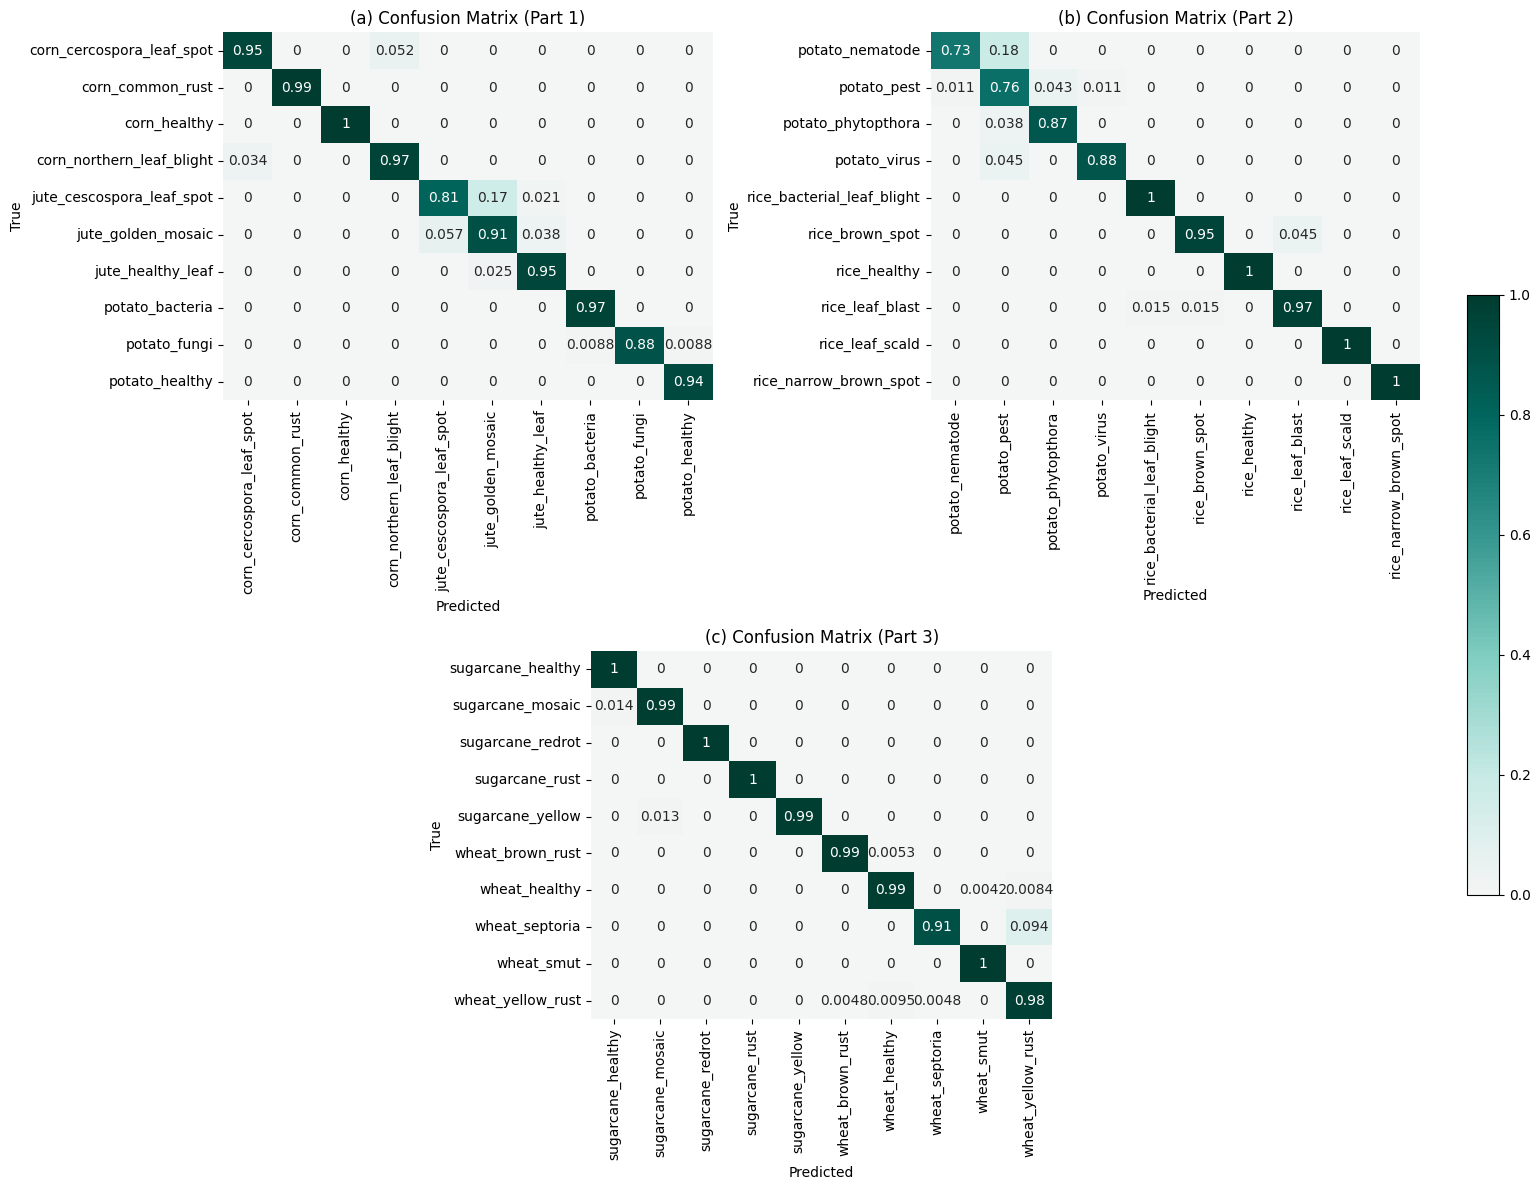

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.gridspec as gridspec

cm = confusion_matrix(all_labels, all_preds, normalize="true")
n_classes = NUM_CLASSES
split = int(np.ceil(n_classes / 3))

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])

# (a) top-left
ax1 = fig.add_subplot(gs[0, 0])
# (b) top-right
ax2 = fig.add_subplot(gs[0, 1])
# (c) bottom-middle
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1, :], width_ratios=[1, 2, 1])
ax3 = fig.add_subplot(gs_bottom[0, 1])

axes = [ax1, ax2, ax3]
titles = ['(a) Confusion Matrix (Part 1)',
          '(b) Confusion Matrix (Part 2)',
          '(c) Confusion Matrix (Part 3)']

heatmap_cmap = "BrBG"  # same style as your reference

# We’ll store the last heatmap object to use its colorbar
hm = None
for i, ax in enumerate(axes):
    start, end = i * split, min((i + 1) * split, n_classes)
    hm = sns.heatmap(cm[start:end, start:end],
                     annot=True, cmap=heatmap_cmap, center=0,
                     xticklabels=test_ds.classes[start:end],
                     yticklabels=test_ds.classes[start:end],
                     ax=ax, cbar=False)  # suppress individual bars

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(titles[i])

# Add one shared colorbar for all
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(hm.collections[0], cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.savefig(os.path.join(results_dir, "confusion_matrix_combined.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [22]:
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)

        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

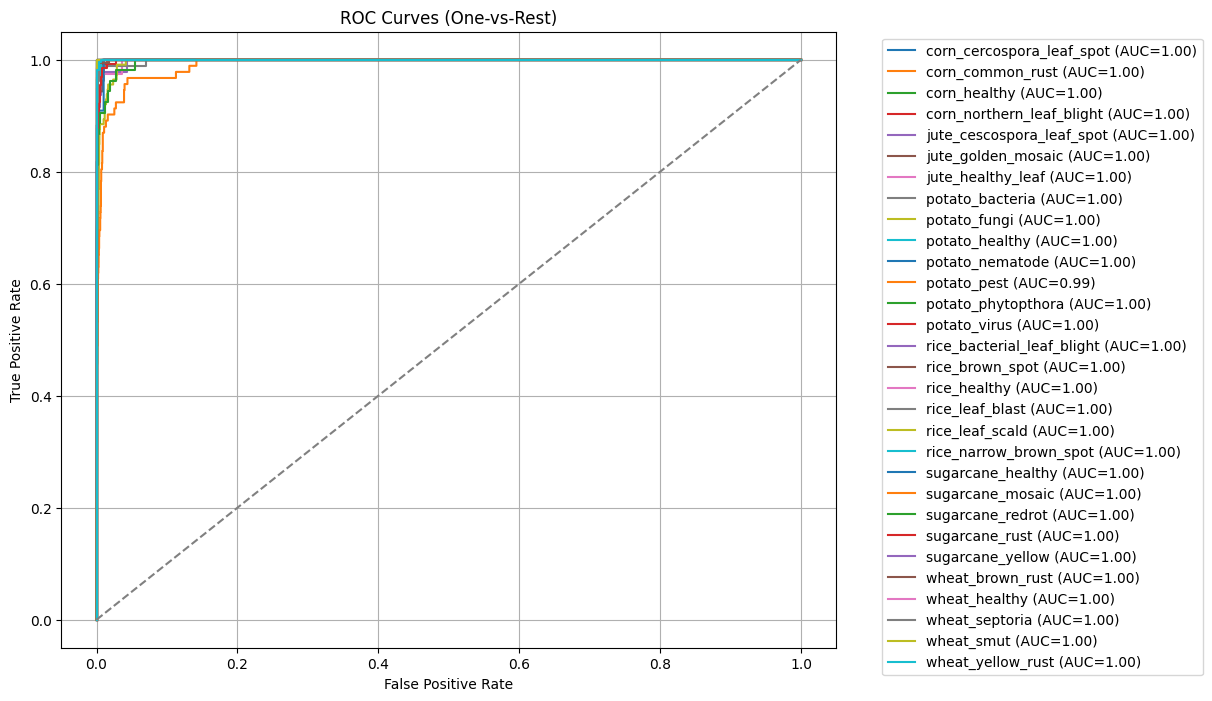

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))

plt.figure(figsize=(10,8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{test_ds.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.savefig(os.path.join(results_dir, "roc_curves.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(y_true[:, i], all_probs[:, i])
    ap = average_precision_score(y_true[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f"{test_ds.classes[i]} (AP={ap:.2f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.savefig(os.path.join(results_dir, "precision_recall_curves.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

NameError: name 'y_true' is not defined

<Figure size 1000x800 with 0 Axes>

In [12]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Load the model
model.load_state_dict(torch.load("C:/Users/ZA SEYAM/AgroFusionNet/models/trained/AgroSpectraNet.pt", map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names
class_names = test_ds.classes

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, digits=4)

# Convert to DataFrame for Table X
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(4)
df_report.to_csv("C:/Users/ZA SEYAM/AgroFusionNet/results/classification_metrics_table.csv", index=True)
print(df_report)

                            precision  recall  f1-score    support
corn_cercospora_leaf_spot      0.9359  0.9481    0.9419    77.0000
corn_common_rust               1.0000  0.9944    0.9972   179.0000
corn_healthy                   1.0000  1.0000    1.0000   175.0000
corn_northern_leaf_blight      0.9728  0.9662    0.9695   148.0000
jute_cescospora_leaf_spot      0.9268  0.8085    0.8636    47.0000
jute_golden_mosaic             0.8421  0.9057    0.8727    53.0000
jute_healthy_leaf              0.9268  0.9500    0.9383    40.0000
potato_bacteria                0.9432  0.9651    0.9540    86.0000
potato_fungi                   0.8547  0.8850    0.8696   113.0000
potato_healthy                 0.8056  0.9355    0.8657    31.0000
potato_nematode                0.8889  0.7273    0.8000    11.0000
potato_pest                    0.7955  0.7609    0.7778    92.0000
potato_phytopthora             0.8846  0.8679    0.8762    53.0000
potato_virus                   0.9355  0.8788    0.9062    66.